# R-HyDAMO

This model generator developed by HKV makes it possible to create a Ribasim model from D-Hydro output files. For more information about Ribasim, please take a look at https://deltares.github.io/Ribasim/ which is constructed by Deltares.

Note that this is a notebook still under construction. This is a temporary version. If there are any questions or comments, please let us know via the GitHub environment.

# Import relevant libraries, functions and data

In [1]:
#import relevant libraries
import ribasim
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import geopandas as gpd
import xarray as xr
import ugrid as ug
from ugrid import UGrid, UGridNetwork1D
import xugrid as xu
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry import Point, LineString
import timeit
import os

In [2]:
#import custom functions
from Functions.custom_functions import *

The output folder of D-Hydro should contain a _map.nc file. This netCDF file will be the main source of data to construct the Ribasim model. 

First, load in this netCDF file by defining the the path to the nc file and check whether the network including the waterlevel looks like expected.

In [3]:
#some variables loaded in through xarray are not compatible with xugrid. Use these for now, change later.
nc_path =  r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaam_v4\Project1.dsproj_data\HoogeRaam\output\HoogeRaam_map.nc"
map_file = xr.open_dataset(nc_path)

edge_nodes = map_file['mesh1d_edge_nodes']
x_coordinates_nodes = map_file['mesh1d_node_x']
y_coordinates_nodes = map_file['mesh1d_node_y']
del(map_file)

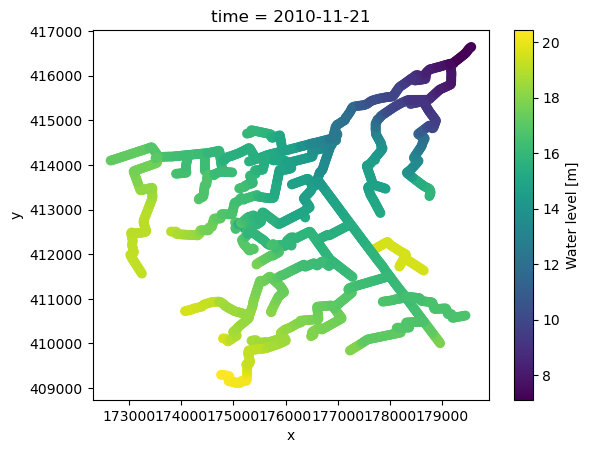

In [4]:
nc_path =  r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaam_v4\Project1.dsproj_data\HoogeRaam\output\HoogeRaam_map.nc"
map_file = xu.open_dataset(nc_path)
map_file["mesh1d_s1"][-1].ugrid.plot(cmap="viridis") #plot the last timestep of the D-Hydro simulation to get an impression of the model output

In [5]:
map_file['mesh1d_edge_nodes'] = edge_nodes #to be updated, see box above

# Q(h)-relations

One of the main nodes are the TabulatedRatingCurves. These are in essence Q(h) relations. First do some visual inspections before adding this straight to the data.

Coordinates of the nodes and edges are likely to be correct


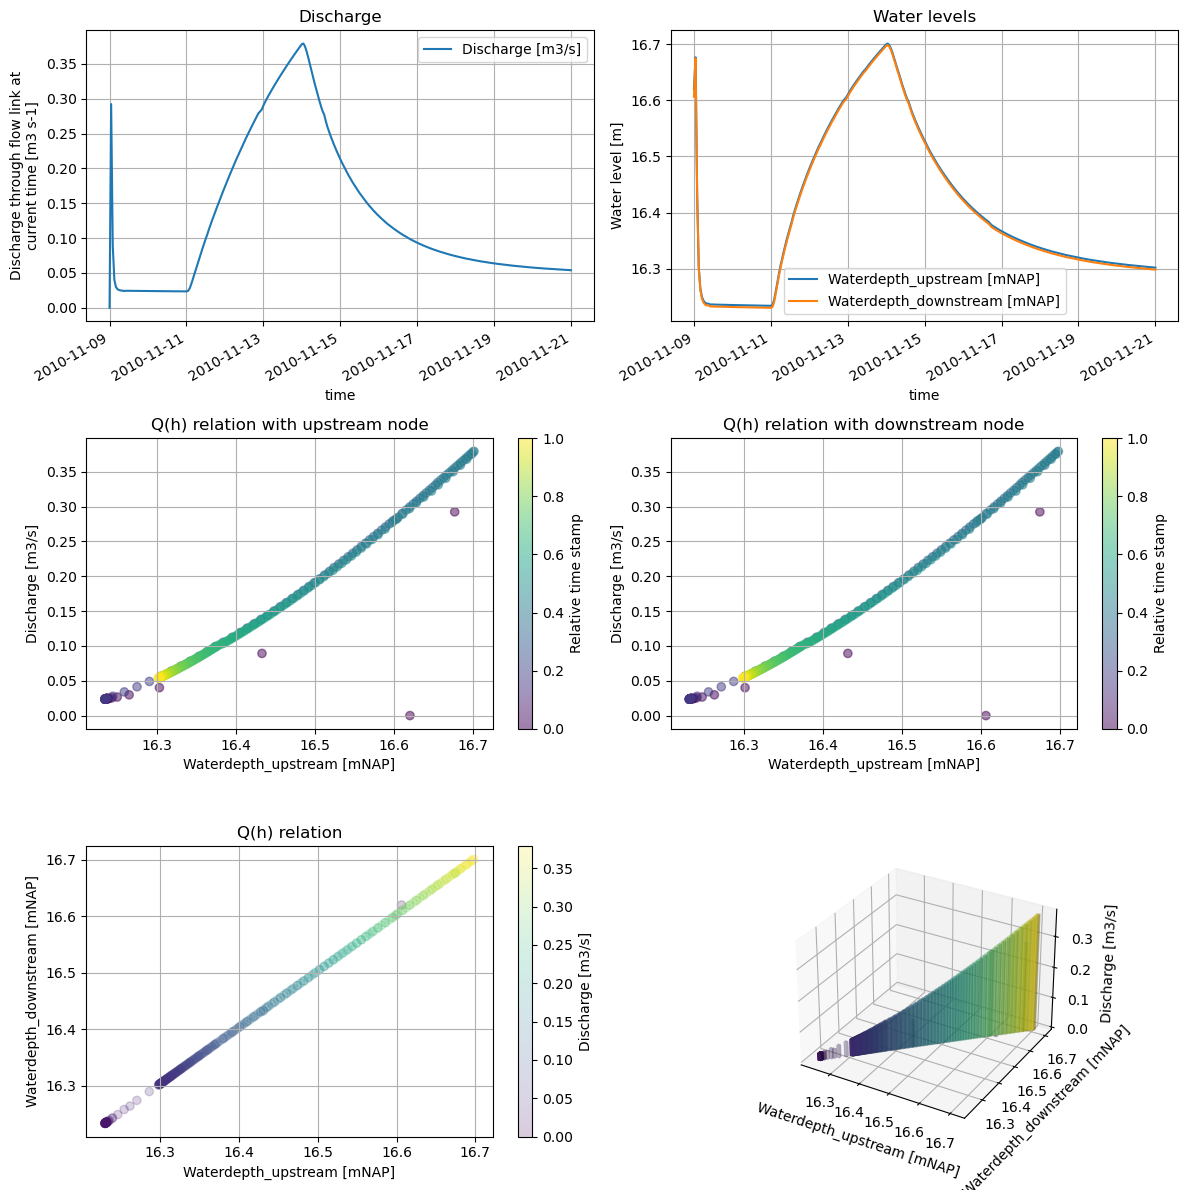

In [6]:
plot_Q_h(Q = map_file['mesh1d_q1'], #discharge
         h = map_file['mesh1d_s1'], #waterlevel
         edges = map_file['mesh1d_edge_nodes'], #connection network between the discharge and waterlevels
         edge_n = 3, #sample
         threeD = True) #whether to plot a 3D figure

# Attribute converter

## TRC, Basins, edges

First the coordinates of each node has to be converted to a basin node in Ribasim. The locations can be retrieved from the map_file.

In [7]:
TRC, basins, edges = attribute_converter(x_coordinates_nodes = map_file['mesh1d_node_x'], 
                                         y_coordinates_nodes = map_file['mesh1d_node_y'], 
                                         edges = map_file['mesh1d_edge_nodes'])
    

# Boundaries

The boundary nodes will first be identified from the map_file. However, they are already present in the regular nodes. Later in the script these nodes will be filtered out of the basin nodes. 

In [8]:
BoundaryNode, Terminal = BoundaryNode_Terminal(x_coordinates_nodes = x_coordinates_nodes,
                                               y_coordinates_nodes = y_coordinates_nodes,
                                               edges = edge_nodes)

#add unique node_id. Continue counting from existing node_id.
start_node_id = max(TRC.node_id.max(), basins.node_id.max())
BoundaryNode.node_id = np.arange(1+ start_node_id, len(BoundaryNode)+start_node_id+1)

start_node_id = max(BoundaryNode.node_id)
Terminal.node_id = np.arange(1+ start_node_id, len(Terminal)+start_node_id+1)

# Filling Q(h) tables

In the beginning of the code we have seen some examples of the Q(h) relationships. Now these should be embedded in tabulated form. Depending on the size of the model, this can take up to several minutes.

In [9]:
TRC_table = fill_Q_h(Q = map_file['mesh1d_q1'], 
                     h = map_file['mesh1d_s1'], 
                     edges = map_file['mesh1d_edge_nodes'], 
                     TRC = TRC, 
                     upstream = True)

Execution time filling the entire TRC: 35.722716 seconds


# Filter attributes and tables

Filter the LevelControl and Terminal from the basin table.

In [10]:
# Filter first the Upstream Boundary nodes out of the basins
filtered_basins = filter_basins_LevelControl(basins = basins, 
                                             LevelControl = BoundaryNode)

# Filter secondly the Terminal(s) out of the basins
filtered_basins = filter_basins_LevelControl(basins = filtered_basins, 
                                             LevelControl = Terminal)

## TRC_table

The TRC_table contains rows with NaN where a terminal is present (if the default option of upstream == True is still present, other wise the filtering has to be done based on the upstream boundaries) 


In [11]:
TRC_table = filter_TRC_Terminal(TRC_table = TRC_table,
                               Terminal = Terminal)

In [12]:
TRC_table

,discharge,level,node_id
0,0.000000,15.161000,2590
1,0.000908,15.169781,2590
2,0.000909,15.169782,2590
3,0.000905,15.169756,2590
4,0.000905,15.169757,2590
...,...,...,...
747927,0.023162,14.752410,5177
747928,0.023108,14.752251,5177
747929,0.023051,14.752107,5177
747930,0.022998,14.752000,5177


## Update edges

The initially created edges go currently from basin to basin. However, the TabulatedRatingCurves have been added, so the edges should pass these attributes as well.

In [13]:
updated_edges = updating_edges(edges = edges,
                               TRC = TRC)


# Profiles

In [14]:
#dummy profiles for a drainage calculation
profiles1 = pd.DataFrame(columns=['node_id', 'storage', 'area', 'level'])
profiles1.node_id = np.arange(1, len(filtered_basins)+1)
profiles1.storage = 0.
profiles1.area = 0.
profiles1.level = 0.

profiles2 = profiles1.copy(deep = True)
profiles2.storage = 1000
profiles2.area = 100
profiles2.level = 10

profiles = pd.concat([profiles1, profiles2])
profiles.sort_values(by = ['node_id', 'storage'], inplace = True)

# Static forcing

In [15]:
#dummy forcing for a drainage calculation


seconds_in_day = 24 * 3600
precipitation = 0.000 / seconds_in_day
evaporation = 0.000 / seconds_in_day

static = pd.DataFrame(columns= ["node_id", "drainage", "potential_evaporation", "infiltration", "precipitation", "urban_runoff"])
static.node_id = np.arange(1, len(filtered_basins)+1)
static = static.fillna(0.0)

# python Ribasim

## Set up the nodes

In [16]:
# correcte benaming kolommen. to do: aggeregeren met voorgaande blokken code tot één overzicht
basins.loc[:, 'fid'] = np.arange(1, len(basins)+1) 
basins = basins.set_index('fid')

In [17]:
node = ribasim.Node(static = gpd.GeoDataFrame(
                    data = basins['type'],
                    index = basins.index,
                    geometry = basins.geometry,
                    crs = 'EPSG:28992')
                    )

In [18]:
basin = ribasim.Basin(profile=profiles, static=static)

In [19]:
# terminal = Terminal.loc[Terminal['basin_n'] == '482'] #hard coded, to do improve later
# Terminal['node_id'] = 9999 #hard coded, to do improve later

# terminal = ribasim.Terminal(static=terminal)

## Store output

In [21]:
#Setup a model

model = ribasim.Model(
    modelname="Ron",
    node=node,
    edge=updated_edges,
    basin=basin,
    # level_boundary=level_boundary,
    # flow_boundary=flow_boundary,
    # pump=pump,
    # linear_resistance=linear_resistance,
    # manning_resistance=manning_resistance,
    tabulated_rating_curve=TRC,
    # fractional_flow=fractional_flow,
    # terminal=terminal,
    starttime="2020-01-01 00:00:00",
    endtime="2021-01-01 00:00:00",
)

ValidationError: 2 validation errors for Model
edge
  __init__() got an unexpected keyword argument 'from_node_id' (type=type_error)
tabulated_rating_curve
  __init__() got an unexpected keyword argument 'x_s_node' (type=type_error)

# Work in progress

## Work in progress here for the drainage simulation

In [ ]:
filtered_basins = filtered_basins[['NAME_ID', 'type', 'geometry']]
TRC = TRC[['NAME_ID', 'type', 'geometry']]#, 'from_node', 'to_node'] #zou voor duidelijkheid erbij kunnen, maar voor nu from_node en to_node eruit gelaten

if not os.path.exists('Results\Attribute_converter'):
   os.makedirs('Results\Attribute_converter')

updated_edges.to_file(r'Results\Attribute_converter\updated_edges.shp', crs = 'EPSG:28992')
TRC.to_file(r'Results\Attribute_converter\TRC.shp', crs = 'EPSG:28992')
filtered_basins.to_file(r'Results\Attribute_converter\basins.shp', crs = 'EPSG:28992')
edges.to_file(r'Results\Attribute_converter\Edges.shp', crs = 'EPSG:28992')
updated_edges.to_file(r'Results\Attribute_converter\updated_edges.shp', crs = 'EPSG:28992')
BoundaryNode.to_file(r'Results\Attribute_converter\LevelControl_under_construction.shp', crs = 'EPSG:28992')
Terminal.to_file(r'Results\Attribute_converter\basins_under_construction.shp', crs = 'EPSG:28992')

TRC_table.to_csv(r'Results\Attribute_converter\TabulatedRatingCurve.csv')

nodes = pd.concat([basins, TRC, BoundaryNode, Terminal])
nodes.to_file(r'Results\Attribute_converter\Node.gpkg', driver = 'GPKG', crs = 'EPSG:28992')

## Bin

### Fractional flow

In [ ]:
def FractionalFlow(Q, mesh1d_edge_nodes, h, n = 3):
    mesh1d_edge_nodes_f = np.array(mesh1d_edge_nodes).flatten() # flatten the array to a 1D array
    counts = np.bincount(mesh1d_edge_nodes_f) # count the occurrences of each integer
    bifurcations_confluences = np.where(counts > 2)[0]     # get the integers that occur more than twice
    
    
    #voor nu even een voorbeeld waar ik node 3 (2) neem
    rows_with_bicon = mesh1d_edge_nodes[(mesh1d_edge_nodes == n).any(axis=1)] #start and end point of each edge
    indices_with_bicon = np.where(mesh1d_edge_nodes == n)[0] #the corresponding edge
    
    # print(rows_with_bicon)
    # print(indices_with_bicon)
    
    #a bifurcatioin or confluence has usual three edges. However, in case it has more, it is convenient to put it in a loop to avoid missing edges.
    
    flow_to_node, flow_from_node = [], [] #to store the discharges to and from the nodes
    
    # n = corresponding node
   
    count_from, count_to = 0, 0
 
    #plotten tweede rij
    plt.figure(figsize = (10, 10))
    plt.subplot(4, 1, 1)
    
    for j in range(len(indices_with_bicon)):
        
        if rows_with_bicon[j][0] == n: #if the first value of the rows_with_bicon[j] is equal to the node of interest, it means the discharge flows away from the node...
            flow_from_node.append(np.array(Q[:, indices_with_bicon[j]])) #... which means the indices_with_bicon (which corresponds to the edge, and thus discharge) should be added to the flow_from_node 
            flow_from_node[count_from] = np.where(flow_from_node[count_from] < 0.001, np.nan, flow_from_node[count_from]) #test, kijken of dit duidelijker wordt
            plt.plot(flow_from_node[count_from], label = 'flow_from_node')
            count_from +=1
            
        elif rows_with_bicon[j][1] == n:
            flow_to_node.append(np.array(Q[:, indices_with_bicon[j]]))
            flow_to_node[count_to] = np.where(flow_to_node[count_to] < 0.001, np.nan, flow_to_node[count_to]) #test, kijken of dit duidelijker wordt
            plt.plot(flow_to_node[count_to], label = 'flow_to_node')
            count_to +=1
            
        else:
            raise ValueError('The found nodes do not correspond with rows_with_bicon') #later weghalen, is een check voor mezelf
                                
    plt.legend()
    plt.grid()
    plt.title('Discharges, sample =' + str (n))
    plt.xlim(0, 750)
    plt.xlabel('Timestep')
    plt.tight_layout()
    
    
    q_in = sum(flow_to_node)
    q_out = sum(flow_from_node)
    
    FF_to_node, FF_from_node = [], []
    
    for j in range(len(flow_to_node)):
        FF = flow_to_node[j] / q_in
        FF_to_node.append(FF)
        
    for j in range(len(flow_from_node)):
        FF = flow_from_node[j] / q_out
        FF_from_node.append(FF) 
    
    #plotten tweede rij
    plt.figure(figsize = (10, 10))
    plt.subplot(4, 1, 2)
    plt.plot(q_in, label = 'q_in_total', lw = 2)
    plt.plot(q_out, label = 'q_out_total', ls = '--')
    plt.legend()
    plt.grid()
    plt.title('Discharges, sample =' + str (n))
    plt.xlim(0, 750)
    plt.xlabel('Timestep')
    plt.tight_layout()
    
    #plotten derde rij 
    #loop through both inflow and outlfow, plot the fractional flow, and plot
    plt.figure(figsize = (10, 10))
    plt.subplot(4,1,3)
    plt.title('Fractional Flow, sample = ' + str(n))
    for j in range(len(FF_to_node)):
        plt.plot(FF_to_node[j], label = 'FractionalFlow q_in_'+str(j))
    for j in range(len(FF_from_node)):
        plt.plot(FF_from_node[j], label = 'FractionalFlow q_out_'+str(j))
    plt.legend()
    plt.grid()
    plt.xlim(0, 750)
    plt.xlabel('Timestep')
    plt.tight_layout()
    
    
    #vierde rij. Hier moet uiteindelijk de FF relatie met h komen
    plt.figure(figsize = (10, 10))
    plt.subplot(4, 1, 4)
    for j in range(len(flow_to_node)):
        plt.scatter(x = h[:, n],
                    y = FF_to_node[j],
                    label = 'FF to node, ' + str(j),
                    alpha = 0.5)
    for j in range(len(FF_from_node)):
        plt.scatter(x = h[:, n],
                    y = FF_from_node[j],
                    label = 'FF from node, ' + str(j),
                    alpha = 0.5)
    plt.legend()
    plt.grid()
    plt.xlabel('Water level [mNAP]')
    plt.ylabel('Fractional flow [-]')
    plt.title('Fractional Flow over height')
    plt.tight_layout()
    # plt.show()    
    # print('q_out =', q_out)
    # start_node = 7 - 1
    # end_node1 = 8-1
    # end_node2 = 2598-1
                        
#     q1 = Q[:, indices_with_3[0]]
#     q2 = Q[:, indices_with_3[1]]
#     q3 = Q[:, indices_with_3[2]]
#     q4 = abs(q1) + abs(q2)
    
#     q1.plot()
#     q2.plot()
#     q3.plot()
#     q4.plot.line('--')
    # print(bifurcations_confluences)

In [ ]:
FractionalFlow(Q = map_file['mesh1d_q1'], 
               mesh1d_edge_nodes = map_file['mesh1d_edge_nodes'],
               h = map_file['mesh1d_s1'],
               n = 3)

## Experiments

## VolumeTool

In [2]:
# VolumeTool_path = r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaam\Project1.dsproj_data\DFM\input\test_output_TRC.nc"
# VolumeTool = xr.open_dataset(VolumeTool_path)

# VT = xr.open_dataset(VolumeTool)

import netCDF4 as nc
VolumeTool_path = r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaam\Project1.dsproj_data\DFM\input\test_output_TRC.nc"
ds = nc.Dataset(VolumeTool_path)

In [28]:
import netCDF4 as nc
VolumeTool_path = r"D:\Users\Bruijns\Documents\TKI Ribasim\Modellen\HogeRaam_v3\Project1.dsproj_data\Hooge Raam\input\test_output_TRC.nc"
ds = nc.Dataset(VolumeTool_path)

# Print the variable names
for var_name in ds.variables:
    variable = ds.variables[var_name]

    print(var_name)
    print(variable[:])

id
[]
levels
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4]
volume
[]
surface
[]
dead_storage
[]
storage
[]
